In [6]:
from spectral import *
import spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.integrate import cumtrapz
from numpy import linalg as LA

In [2]:
img = spectral.open_image('D1_F12_H1_Cropped.hdr')
print(type(img))

<class 'spectral.io.bilfile.BilFile'>


In [5]:
header ="C:/Users/Yaniv/PycharmProjects/project_stanley/D1_F12_H1_Cropped.hdr"
data = open_image(header)
cube = data.load().copy()
print(np.shape(cube))

(375, 450, 511)


In [16]:
def visual(data, name):  # Visualize the cube
    # Choose four different bands to display
    data = (255 / np.max(data.flatten())) * data
    bands = [10, 20, 30, 40]
    # Create a figure with subplots to display the band images
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    # Display each band image in a subplot
    for band, ax in zip(bands, axes.flat):
        band_image = data[:, :, band]
        ax.imshow(band_image, cmap='gray')
        ax.set_title('Band {}'.format(band))
    plt.suptitle("{}".format(name))
    plt.show()


def plot_pixel_spectra(cube, row, col):  # Visual the target spectral
    pixel_spectra = cube[row, col, :]
    fig, ax = plt.subplots()
    ax.plot(pixel_spectra)
    ax.set_title('Spectral at Row={}, Col={}'.format(row, col))
    ax.set_xlabel('Band Number')
    ax.set_ylabel('Reflectance')
    plt.show()

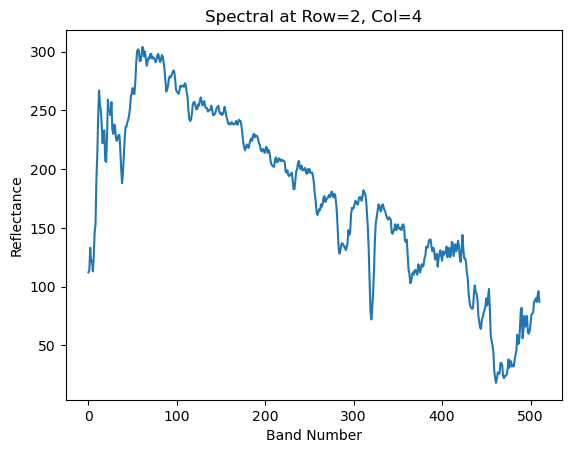

In [17]:
plot_pixel_spectra(cube, 2, 4)  # target

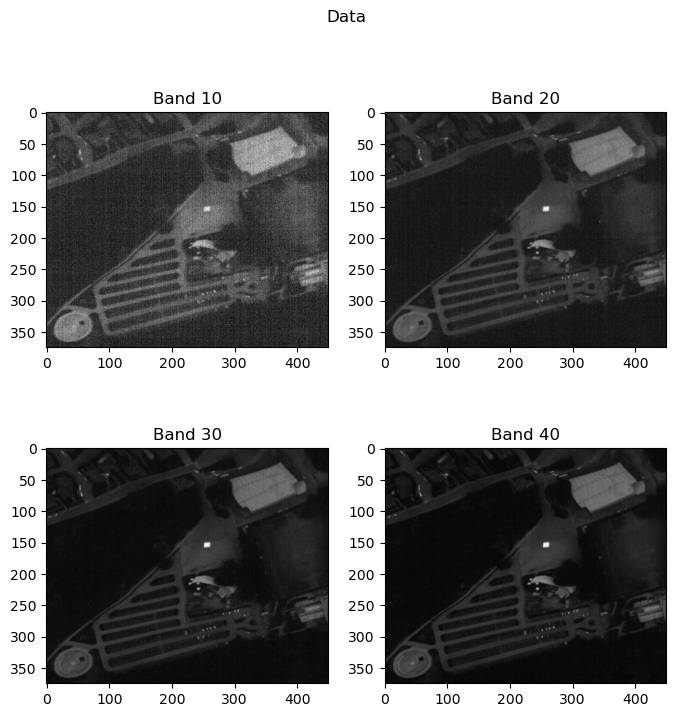

In [9]:
visual(cube, "Data")

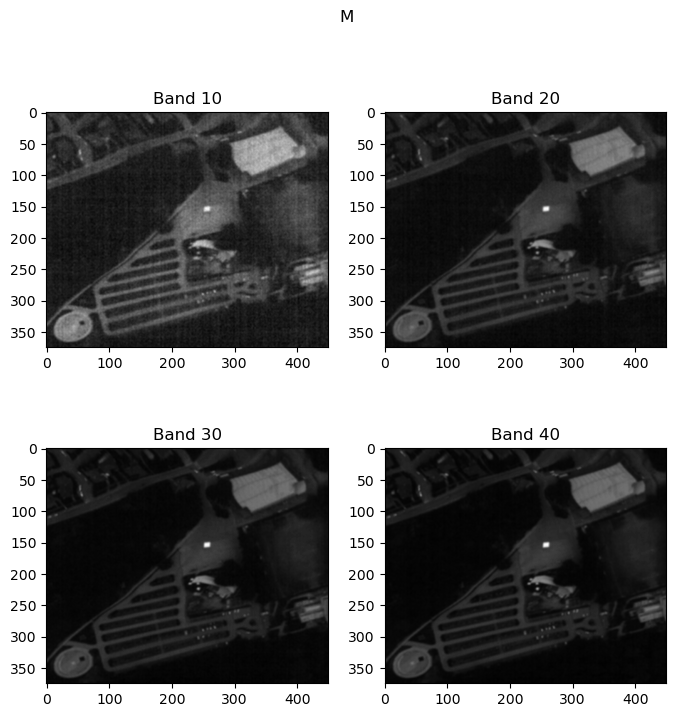

In [10]:
t = cube[2, 4, :]
p = 0.01
M = np.zeros(np.shape(cube))
for i in range(M.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M[:, :, i] = neighbor_sum / (neighbor_count - 1)
X_MINUS_M = np.subtract(cube, M)
arg_cov = X_MINUS_M.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi = np.cov(arg_cov.transpose())  # Transpose- Python vs. Matlab
t_inv_phi = np.dot(t, LA.inv(phi))

visual(M, "M")

In [11]:
MF_NT = np.zeros((img.shape[0], img.shape[1]))
MF_WT = np.zeros((img.shape[0], img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        MF_NT[i, j] = np.dot(t_inv_phi, (cube[i, j, :] - M[i, j, :]))
        MF_WT[i, j] = np.dot(t_inv_phi, (cube[i, j, :] - M[i, j, :] + p * t))

for i in range(4, 20, 5):  # Checking
    print("X_minus_M_NT {},{}:".format(i, i), cube[i, i, 0] - M[i, i, 0])
    print("X_minus_M_WT {},{}:".format(i, i), cube[i, i, 0] - M[i, i, 0] + p * t[0])
print("--------------------")
for i in range(4, 20, 5):  # Checking
    print("MF_NT {},{}:".format(i, i), MF_NT[i, i])
    print("MF_WT {},{}:".format(i, i), MF_WT[i, i])

X_minus_M_NT 4,4: 0.375
X_minus_M_WT 4,4: 1.495
X_minus_M_NT 9,9: -9.0
X_minus_M_WT 9,9: -7.88
X_minus_M_NT 14,14: -0.375
X_minus_M_WT 14,14: 0.7450000000000001
X_minus_M_NT 19,19: -0.625
X_minus_M_WT 19,19: 0.4950000000000001
--------------------
MF_NT 4,4: 33.35878166784747
MF_WT 4,4: 99.46389116902229
MF_NT 9,9: -21.842791123527036
MF_WT 9,9: 44.26231837764766
MF_NT 14,14: 51.031886140910615
MF_WT 14,14: 117.13699564208548
MF_NT 19,19: -16.296544607667556
MF_WT 19,19: 49.80856489350717


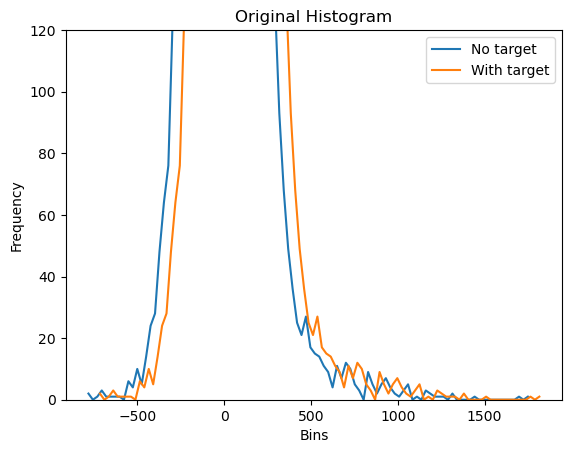

In [12]:
NT_val, NT_bins = np.histogram(MF_NT, bins=100)
WT_val, WT_bins = np.histogram(MF_WT, bins=100)
fig, ax = plt.subplots()
ax.plot(NT_bins[:-1], NT_val, label='No target')
ax.plot(WT_bins[:-1], WT_val, label='With target')
ax.set(title='Original Histogram', xlabel='Bins', ylabel='Frequency')
ax.legend()
plt.ylim(0, 120)
plt.show()

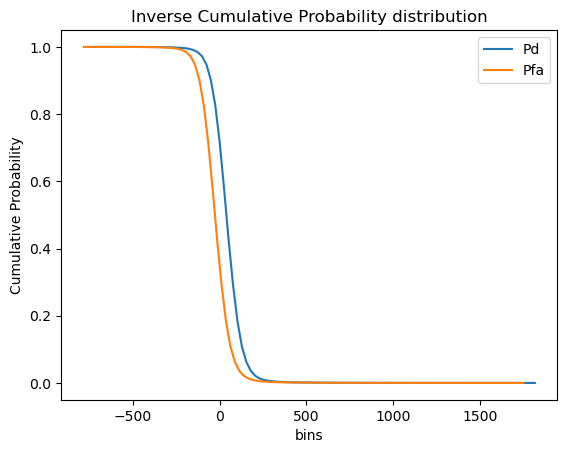

In [13]:
Pd = 1 - (np.cumsum(WT_val) / np.sum(
    WT_val))  # 1-((cumtrapz(WT_val, WT_bins[:-1]))/(cumtrapz(WT_val, WT_bins[:-1])[-1]))
Pfa = 1 - (np.cumsum(NT_val) / np.sum(
    NT_val))  # 1-((cumtrapz(NT_val, NT_bins[:-1]))/(cumtrapz(NT_val, NT_bins[:-1])[-1]))

plt.plot(WT_bins[:-1], Pd, label="Pd")
plt.plot(NT_bins[:-1], Pfa, label="Pfa")
plt.xlabel('bins')
plt.ylabel('Cumulative Probability')
plt.title('Inverse Cumulative Probability distribution')
plt.legend()
plt.show()

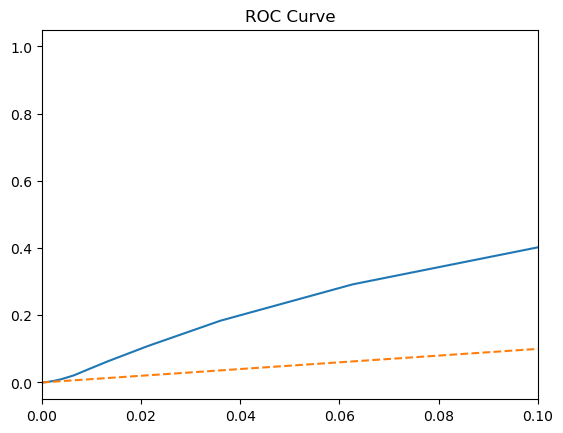

In [14]:
th = 0.1
index = max(100 - np.argmax(WT_bins > NT_bins[-1]), np.argmax(NT_bins > WT_bins[0]))
Pd_new = np.pad(Pd, (index, 0), mode='constant', constant_values=(1, 1))
Pfa_new = np.pad(Pfa, (0, index), mode='constant', constant_values=(0, 0))

plt.plot(Pfa_new, Pd_new)
plt.plot([0, th], [0, th], '--')
plt.title('ROC Curve')
plt.xlim(0, th)
plt.show()

In [15]:
Pd_new = np.flip(Pd_new)
Pfa_new = np.flip(Pfa_new)


def area(th):
    cond = np.where(Pfa_new > th)[0][0]
    Pd_mask = Pd_new.copy()
    Pd_mask[cond:] = 0
    A = cumtrapz(Pd_mask, Pfa_new)
    return (A - 0.5 * pow(th, 2)) / (th - 0.5 * pow(th, 2))


print("Performance, using 'area test':")
print("th= 0.001:", area(0.001)[-1])
print("th= 0.01:", area(0.01)[-1])
print("th= 0.1:", area(0.1)[-1])

Performance, using 'area test':
th= 0.001: 0.00015855060589282686
th= 0.01: 0.015341601284888083
th= 0.1: 0.11765503889105476
